Basic scikits-leaarn toolchain msetup

In [53]:
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.cross_validation import train_test_split

In [54]:
RANDOM_SEED = 1001

In [55]:
signal = pd.DataFrame.from_csv('../ML_Events/signal/out_sig.txt', index_col= 0, sep='\t')
background = pd.DataFrame.from_csv('../ML_Events/background/out_bk.txt', index_col= 0, sep='\t')
signal.columns = background.columns = [s.strip() for s in signal.columns]

#Drop empy columns
emptycols = [c for c in signal.columns if c.startswith("Empty")]
signal.drop(emptycols, axis=1, inplace=True)
background.drop(emptycols, axis=1, inplace=True)

#Balance signal and background weights. Otherwise saying that everything is a signal is a cheap
#local minimum.
background.Weight *= signal.Weight.sum()/ background.Weight.sum()


data = pd.concat([signal, background])
features, weights = data.iloc[:, :-1], data.iloc[:,-1]
weights = np.abs(weights).as_matrix()
labels = np.r_[np.ones(len(signal)), np.zeros(len(background))]

#We split between testing and training by further starifying on weights, by ignoring the smaller ones for each
#category (for the purposes of splitting, we assign them to a third category '2' that tunrns out to be split evenly as well).
weighted_cats = labels.copy()
label_mask = labels.astype(bool)
small_signal = (weights < weights[label_mask].mean()) & label_mask
weighted_cats[small_signal] = 2

small_background = (weights < weights[~label_mask].mean()) & ~label_mask
weighted_cats[small_background] = 2


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, labels, weights,
                                                                     random_state = RANDOM_SEED, 
                                                                     test_size=0.5, stratify=weighted_cats)



#X_train, y_train, w_train = features, labels, weights

cols = features.columns

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   3.,    2.,   11.,   57.,  117.,  199.,  440.,  448.,  716.,  669.]),
 array([-17.10343741, -15.18956331, -13.2756892 , -11.3618151 ,
         -9.447941  ,  -7.53406689,  -5.62019279,  -3.70631868,
         -1.79244458,   0.12142952,   2.03530363]),
 <a list of 10 Patch objects>)

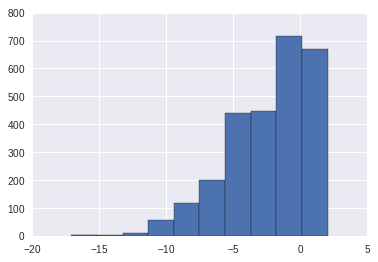

In [57]:
plt.hist(np.log10(weights))

In [58]:
len(data)

2662

In [59]:
sum(w_test)

2252.8113622554929

In [60]:
sum(w_train)

2140.0857696105859

In [61]:
sum(y_train*w_train)

1107.5629157999799

In [62]:
sum(y_test*w_test)

1100.6161157377237

In [63]:
len(cols)

17

In [64]:
clf = Classifier(n_estimators=1000, 
                 learning_rate=2,
                 #max_depth=10,
                 #criterion = "gini",
                 #max_features = 3,
                 min_weight_fraction_leaf=0.01,
                 #bootstrap = False,
                 #oob_score=True,
                 #class_weight="balanced_subsample",
                 #n_jobs=cpu_count(),
                 subsample=0.3,
                 random_state=RANDOM_SEED)

In [65]:
clf.fit(X_train,y_train, sample_weight=w_train)

GradientBoostingClassifier(init=None, learning_rate=2, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=1000,
              presort='auto', random_state=1001, subsample=0.3, verbose=0,
              warm_start=False)

In [66]:
clf.score(X_test, y_test, sample_weight=w_test)

0.57016810075918667

In [67]:
clf.score(X_train, y_train, sample_weight=w_train)

0.60672235071359581

In [68]:
from smpdflib.initialization import init_style
init_style()

In [69]:
plt.hist(est_scores, bins=40)
plt.xlabel("Estimation scores of individual decision trees")
plt.savefig("ind_dt_dist.pdf")

NameError: name 'est_scores' is not defined

In [70]:
sum(w_test)

2252.8113622554929

In [71]:
sum(w_train)

2140.0857696105859

In [72]:
importances = clf.feature_importances_

In [73]:
import matplotlib.pyplot as plt

In [74]:
importances = pd.Series(importances, index=features.columns)

In [75]:
sv = importances.sort_values()
c,d = sv.index[-2:]

In [76]:
best_features = sv.index[-4:]

In [77]:
sv

N of jets                        0.012430
m l1, l2                         0.016102
j1 pT                            0.019649
| Delta eta l1,l2 |              0.021559
m j1, j2                         0.026013
Centrality                       0.030460
| Delta Phi l1, l2 |             0.041242
Delta R j1,j2                    0.042665
Zeppenfeld Var                   0.049293
Cos |tot phi|                    0.068701
W pT                             0.074866
mET phi                          0.079319
j2 pT                            0.085040
mET (scalar)                     0.088530
| Delta eta j1,j2 |              0.099523
Cos | deltaphi(j1+j2,l1+l2) |    0.104045
dijet min distance               0.140562
dtype: float64

In [78]:
best_features

Index(['mET (scalar)', '| Delta eta j1,j2 |', 'Cos | deltaphi(j1+j2,l1+l2) |',
       'dijet min distance'],
      dtype='object')

mET (scalar)
mET (scalar)
mET (scalar)
| Delta eta j1,j2 |
| Delta eta j1,j2 |
Cos | deltaphi(j1+j2,l1+l2) |


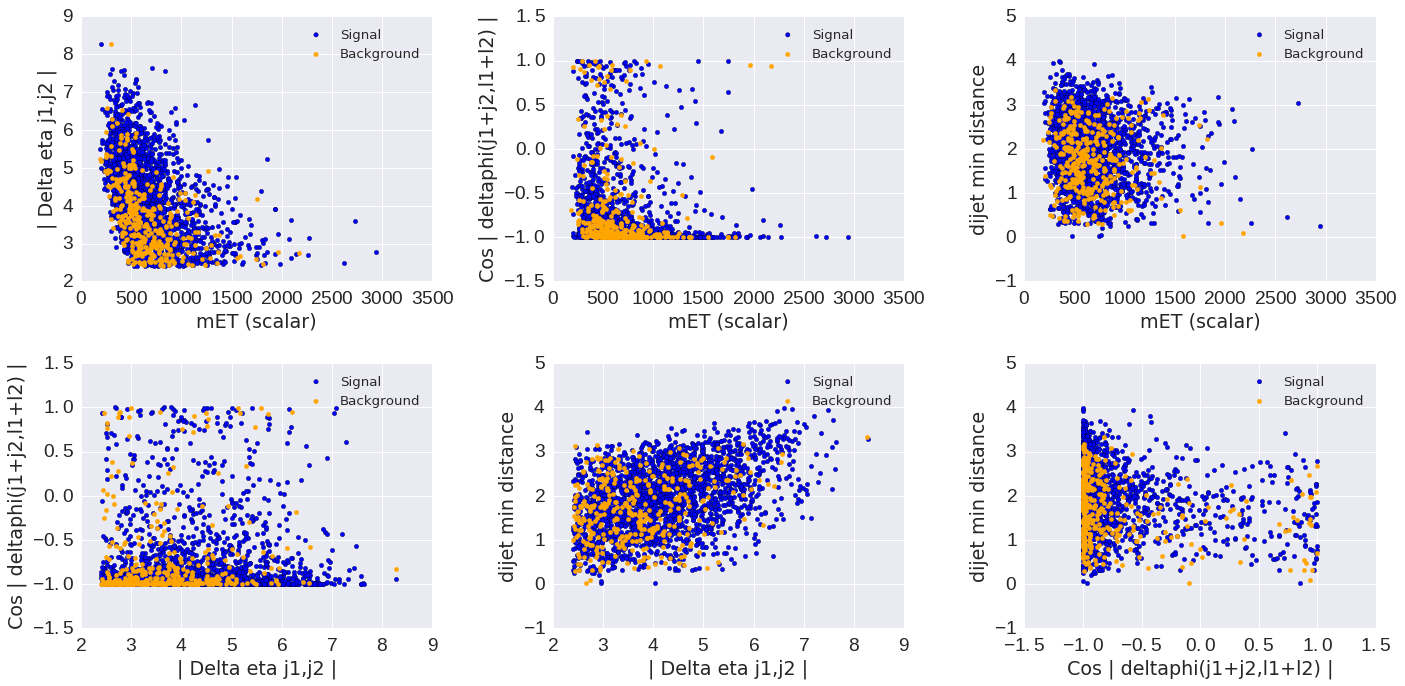

In [79]:
import itertools
pairs = (itertools.combinations(best_features,2))
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axiter = (ax  for l in axes for ax in l)
for (c,d), ax in zip(pairs, axiter):
    print(c)
    ax.scatter(c,d, data=signal, label="Signal")
    ax.scatter(c,d, data=background, color='orange', label="Background")
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.legend(loc='best')
plt.tight_layout()
plt.savefig("features.pdf")
    

In [80]:
proba_test = clf.predict_proba(X_test)

In [81]:
import seaborn

In [82]:
import statsmodels.api as sm

In [88]:
cols

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |'],
      dtype='object')

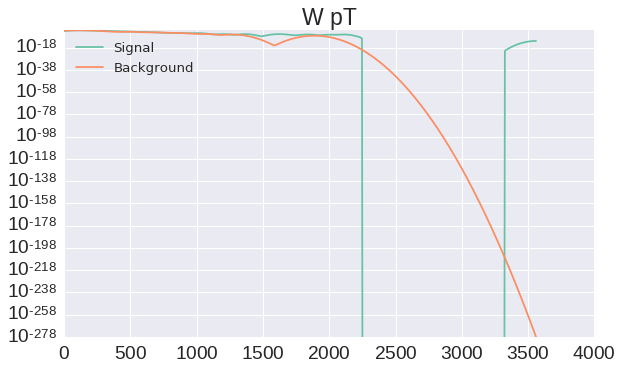

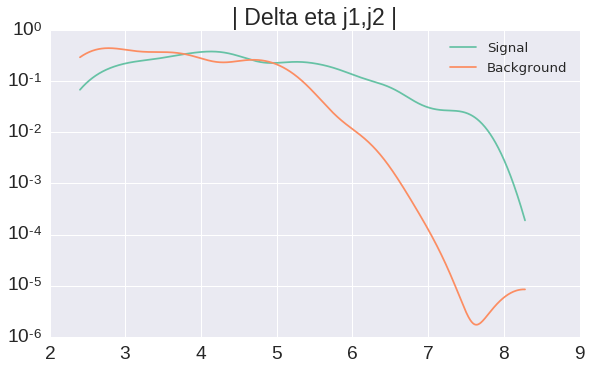

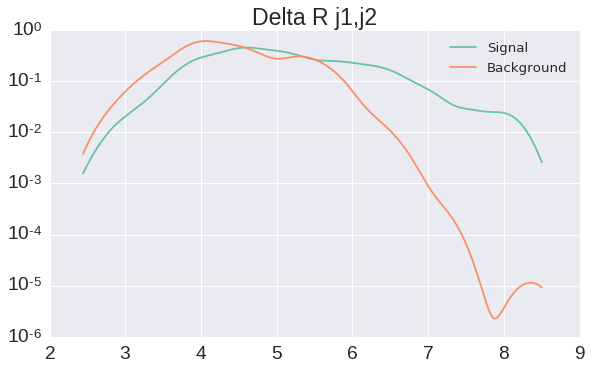

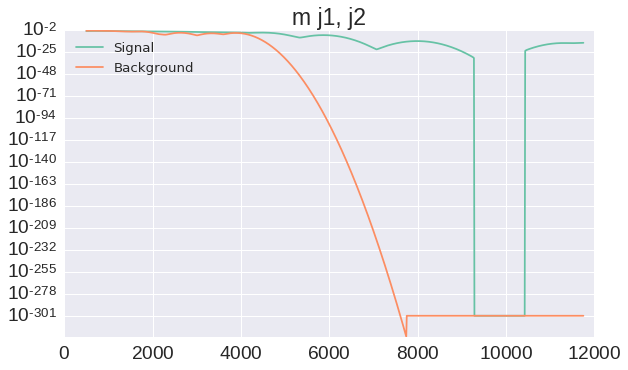

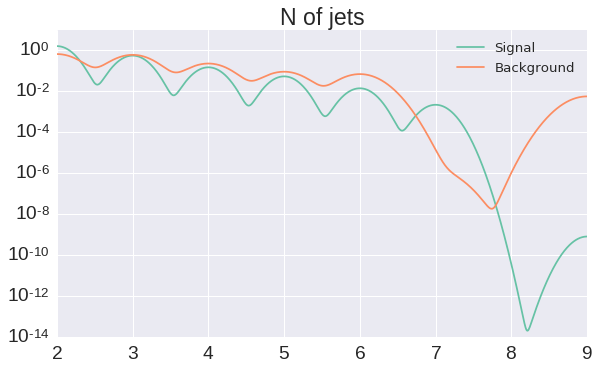

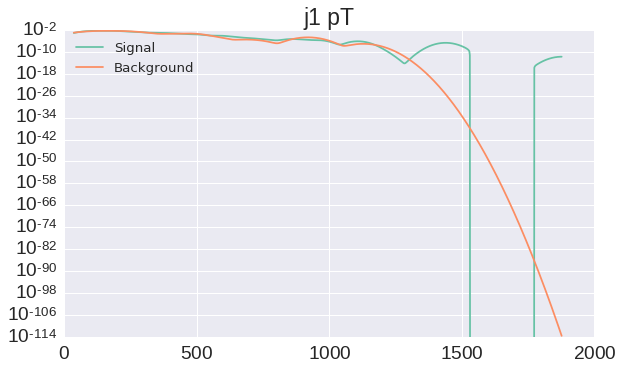

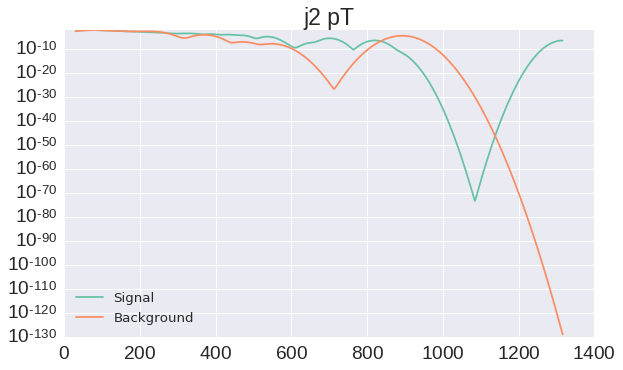

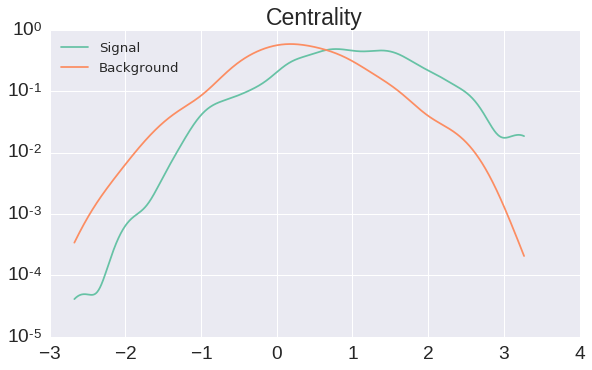

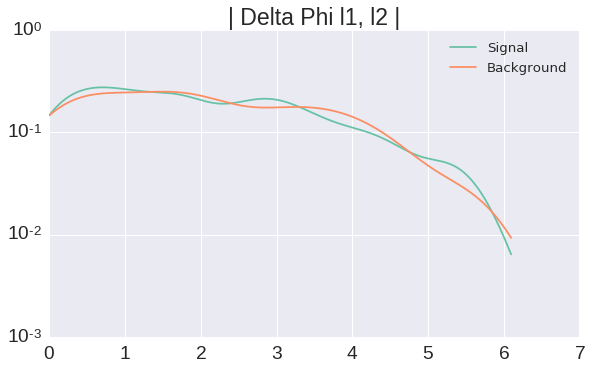

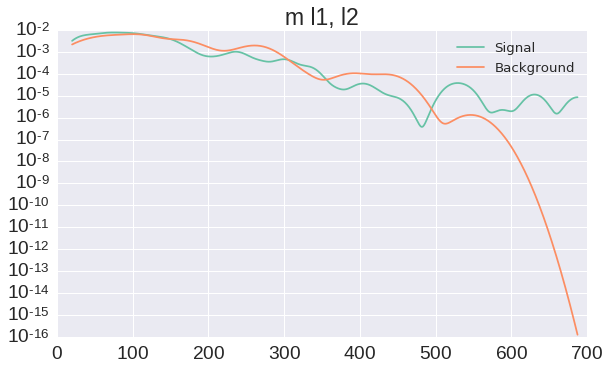

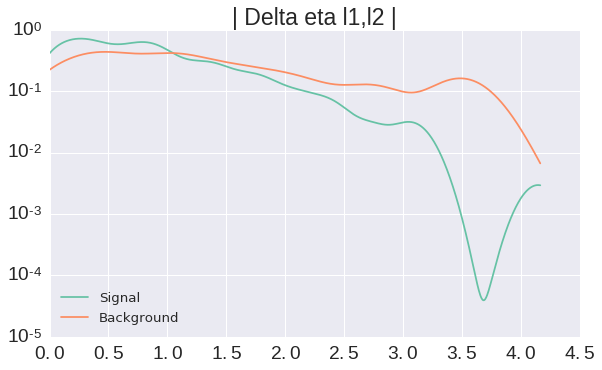

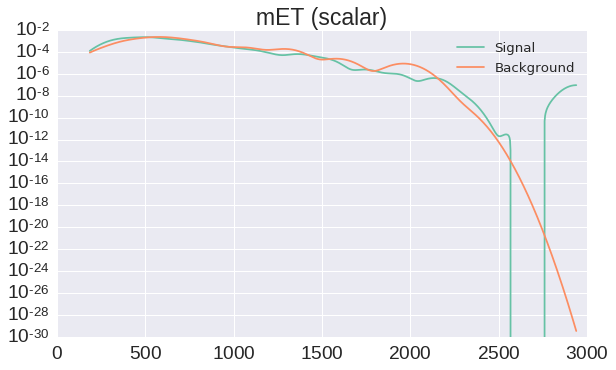

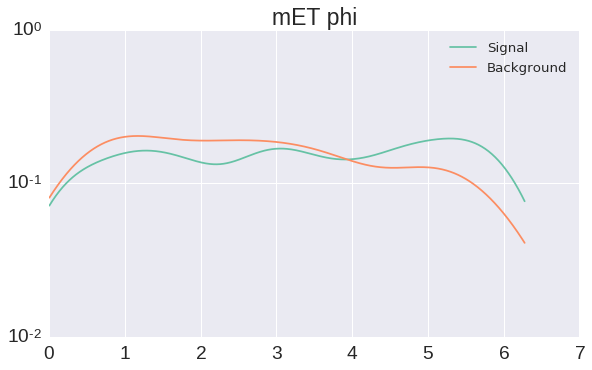

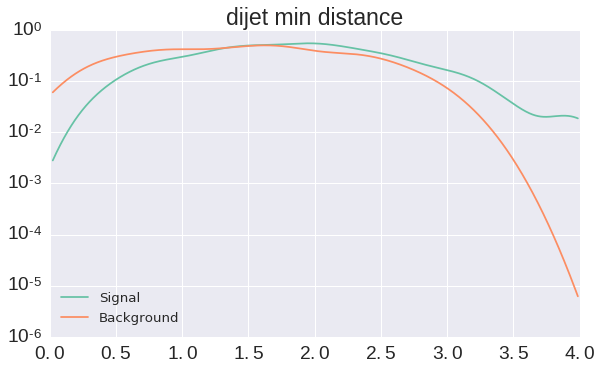

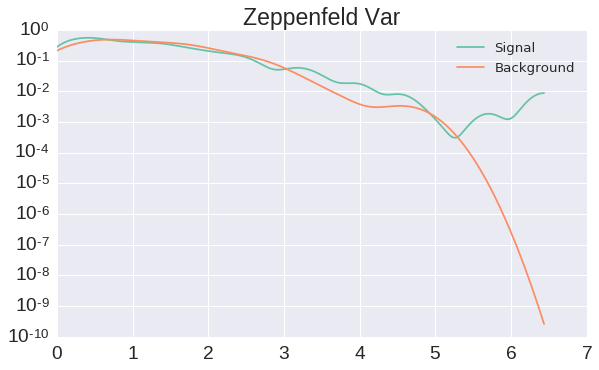

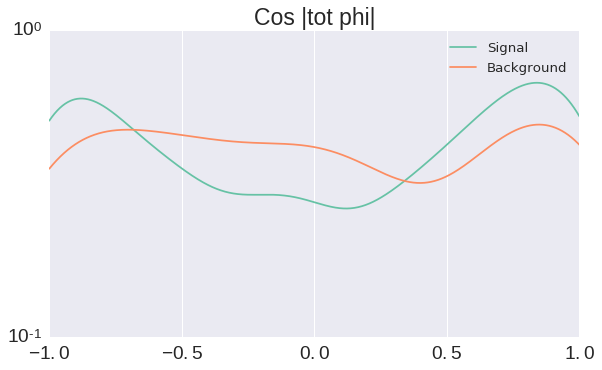

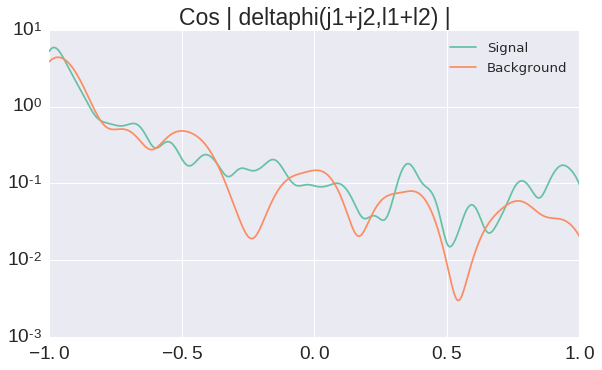

In [91]:
for feature in cols:
    
    dens_sig = sm.nonparametric.KDEUnivariate(signal[feature].as_matrix())
    dens_sig.fit(weights=signal.Weight.as_matrix(), fft=False)

    dens_bg= sm.nonparametric.KDEUnivariate(background[feature].as_matrix())
    dens_bg.fit(weights=background.Weight.as_matrix(), fft=False)
    plt.figure()
    plt.title(feature)
    
    x = np.linspace(data[feature].min(), data[feature].max(), 1000)
    plt.plot(x, dens_sig.evaluate(x), label="Signal")
    plt.plot(x, dens_bg.evaluate(x), label="Background")
    plt.yscale("log")
    plt.legend()

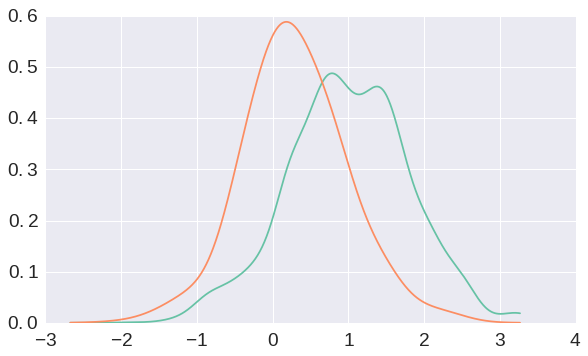

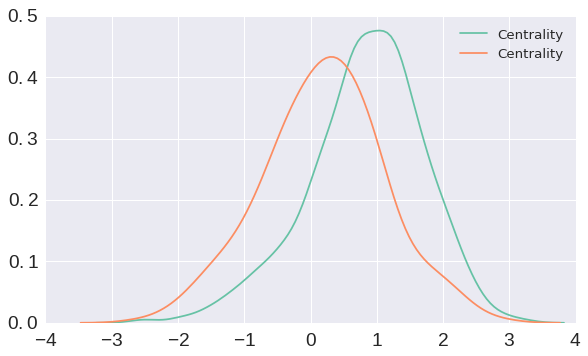

In [85]:
seaborn.kdeplot(signal.Centrality)
seaborn.kdeplot(background.Centrality)

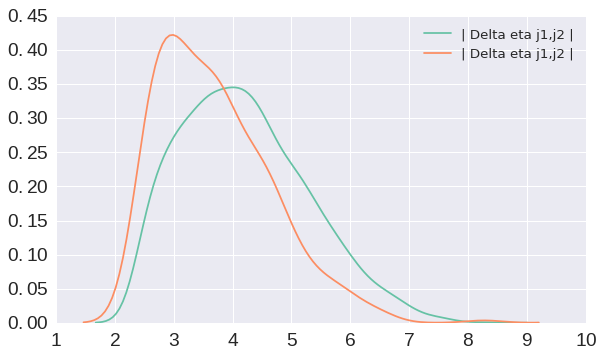

In [86]:
f1 = '| Delta eta j1,j2 |'
seaborn.kdeplot(signal['| Delta eta j1,j2 |'])
seaborn.kdeplot(background['| Delta eta j1,j2 |'])

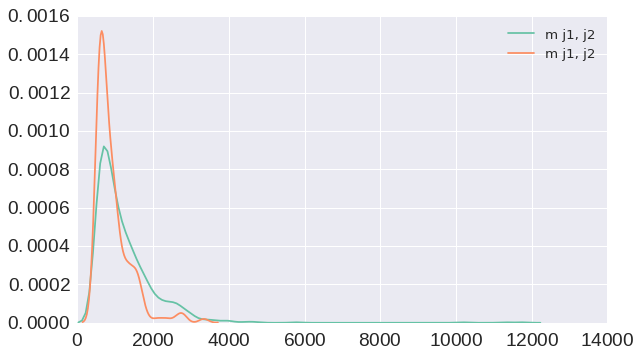

In [490]:
f2 = 'm j1, j2'
seaborn.kdeplot(signal[f2])
seaborn.kdeplot(background[f2])

In [491]:
from sklearn.lda import LDA

In [458]:
lda = LDA().fit(X_train[[f1,f2]], y_train)

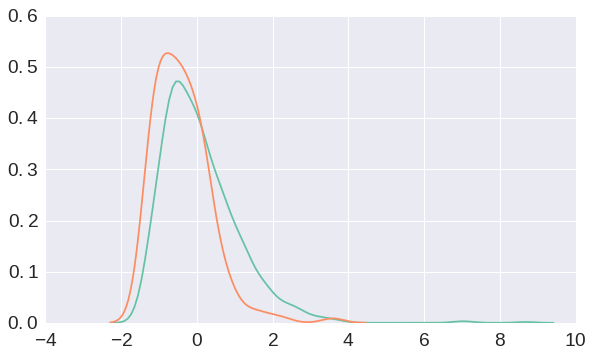

In [459]:
nf_s = lda.transform(signal[[f1,f2]]).ravel()
nf_b = lda.transform(background[[f1,f2]]).ravel()
seaborn.kdeplot(nf_s)
seaborn.kdeplot(nf_b)

In [460]:
predicted_test = clf.predict_proba(X_test)[:,1]
predicted_train = clf.predict_proba(X_train)[:,1]

In [461]:
from sklearn.metrics import roc_auc_score, roc_curve

In [462]:
roc_curve??

In [492]:

fpr, tpr, thresholds = roc_curve(y_test, predicted_test, sample_weight=w_test)
#fpr, tpr, thresholds = roc_curve(y_train, predicted_train, sample_weight=w_train)

(0, 1)

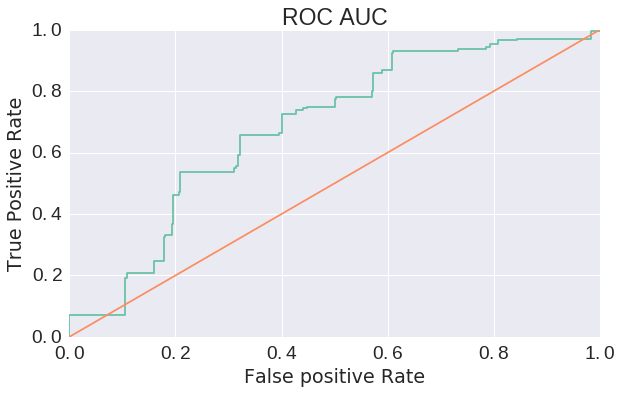

In [493]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title("ROC AUC")
plt.xlabel("False positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)

In [500]:
roc_auc_score(y_test, predicted_test, sample_weight=w_test)

0.6854501496222386

In [116]:
clf.classes_

array([ 0.,  1.])

In [117]:
probs = np.linspace(0,1,30)

In [161]:
t = clf.estimators_[0].tree_

In [166]:
clf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.05,
            presort=False, random_state=1438136084, splitter='best')

In [167]:
from sklearn.tree import export_graphviz

In [169]:
export_graphviz??

In [170]:
export_graphviz(t, feature_names=features.columns)

In [61]:
clf.classes_

array([ 0.,  1.])

In [64]:
clf.predict_proba(signal[cols])[:,1];

In [86]:
sp = clf.predict_proba(signal[cols])[:,1]
bp = clf.predict_proba(background[cols])[:,1]

In [87]:
import seaborn

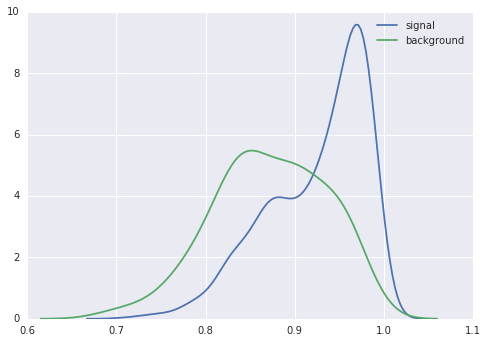

In [88]:
seaborn.kdeplot(sp, label="signal")
seaborn.kdeplot(bp, label="background")

In [89]:
seaborn.kdeplot??

(array([ 7.50663757,  3.39179815,  0.        ,  2.68089836,  1.56989949,
         0.37545856,  1.29775009,  2.45335258,  3.84913081,  4.98120766,
         7.81494068,  6.18388802,  1.57942372,  1.77767874,  2.47507472,
         2.2654904 ,  8.55065445,  2.51594643,  2.46520586,  3.00442134]),
 array([ 0.68766668,  0.70265045,  0.71763423,  0.732618  ,  0.74760178,
         0.76258555,  0.77756933,  0.7925531 ,  0.80753688,  0.82252065,
         0.83750443,  0.8524882 ,  0.86747198,  0.88245575,  0.89743952,
         0.9124233 ,  0.92740707,  0.94239085,  0.95737462,  0.9723584 ,
         0.98734217]),
 <a list of 20 Patch objects>)

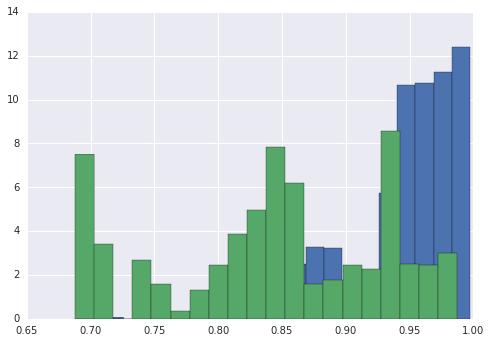

In [100]:
plt.hist(sp, weights=signal.Weight, normed=True, bins=20)
plt.hist(bp, weights=background.Weight, normed=True, bins=20)

In [102]:
clf.predict_proba(X_test)

array([[ 0.06339966,  0.93660034],
       [ 0.12755741,  0.87244259],
       [ 0.01987332,  0.98012668],
       ..., 
       [ 0.13213656,  0.86786344],
       [ 0.01284407,  0.98715593],
       [ 0.03189404,  0.96810596]])

In [104]:
clf.predict(X_train)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1